## Import Libraries

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from IPython.display import Markdown, display
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder


## Import Dataset

Data Source: https://www.kaggle.com/benroshan/ecommerce-data

In [2]:
df_LOD = pd.read_csv(r'D:/Python Projects/Data Mining-Tubes/data/raw/List of Orders.csv')
df_OD = pd.read_csv(r'D:/Python Projects/Data Mining-Tubes/data/raw/Order Details.csv')
df_ST = pd.read_csv(r'D:/Python Projects/Data Mining-Tubes/data/raw/Sales Target.csv')

In [3]:
display(Markdown("Gambaran singkat dataset List of Orders {0}:".format(df_LOD.shape)))
display(df_LOD.head())
display(Markdown("Gambaran singkat dataset Order Details {0}:".format(df_OD.shape)))
display(df_OD.head())
display(Markdown("Gambaran singkat dataset Sales Target {0}:".format(df_ST.shape)))
display(df_ST.head())

Gambaran singkat dataset List of Orders (560, 5):

,Order ID,Order Date,CustomerName,State,City
0,B-25601,01-04-2018,Bharat,Gujarat,Ahmedabad
1,B-25602,01-04-2018,Pearl,Maharashtra,Pune
2,B-25603,03-04-2018,Jahan,Madhya Pradesh,Bhopal
3,B-25604,03-04-2018,Divsha,Rajasthan,Jaipur
4,B-25605,05-04-2018,Kasheen,West Bengal,Kolkata


Gambaran singkat dataset Order Details (1500, 6):

,Order ID,Amount,Profit,Quantity,Category,Sub-Category
0,B-25601,1275.0,-1148.0,7,Furniture,Bookcases
1,B-25601,66.0,-12.0,5,Clothing,Stole
2,B-25601,8.0,-2.0,3,Clothing,Hankerchief
3,B-25601,80.0,-56.0,4,Electronics,Electronic Games
4,B-25602,168.0,-111.0,2,Electronics,Phones


Gambaran singkat dataset Sales Target (36, 3):

,Month of Order Date,Category,Target
0,Apr-18,Furniture,10400.0
1,May-18,Furniture,10500.0
2,Jun-18,Furniture,10600.0
3,Jul-18,Furniture,10800.0
4,Aug-18,Furniture,10900.0


## Data Preprocessing

---

### Data Cleaning

---

#### Handling Missing Values

Pertama, kami akan mendeteksi jumlah *missing values* pada setiap kolom di seluruh dataset.

In [4]:
display(df_LOD.isnull().sum())
display(df_OD.isnull().sum())
display(df_ST.isnull().sum())


Order ID        60
Order Date      60
CustomerName    60
State           60
City            60
dtype: int64

Order ID        0
Amount          0
Profit          0
Quantity        0
Category        0
Sub-Category    0
dtype: int64

Month of Order Date    0
Category               0
Target                 0
dtype: int64

Terlihat bahwa seluruh *missing values* hanya terletak di dataset ***List of Orders***. Selanjutnya, kami akan memeriksa posisi indeks *missing values* pada dataset tersebut.

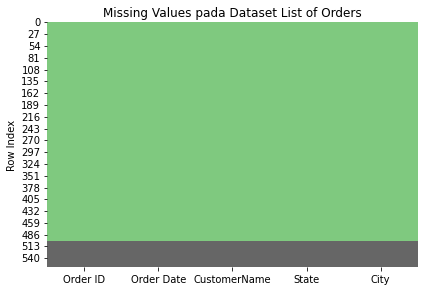

In [5]:
sns.heatmap(df_LOD.isnull(), cmap="Accent", cbar=False)
plt.ylabel("Row Index")
plt.tight_layout()
plt.title("Missing Values pada Dataset List of Orders")
plt.show()

Terlihat bahwa semua *missing values* terletak pada indeks baris yang sama pada setiap kolom, sehingga kami bisa menghapus *missing values* tersebut dari dataset.

In [6]:
df_LOD.dropna(inplace=True)

---

### Data Transformation

---

Selanjutnya, kita akan melihat tipe data dari setiap kolom pada seluruh dataset.

In [7]:
display(df_LOD.dtypes)
display(df_OD.dtypes)
display(df_ST.dtypes)

Order ID        object
Order Date      object
CustomerName    object
State           object
City            object
dtype: object

Order ID         object
Amount          float64
Profit          float64
Quantity          int64
Category         object
Sub-Category     object
dtype: object

Month of Order Date     object
Category                object
Target                 float64
dtype: object

Terlihat banyak kolom yang belum mempuyai tipe data yang sesuai, oleh karena itu kami akan mengkonversi tipe data pada kolom-kolom berikut:
- Dataset *List of Orders*: Kolom *Order Date* menjadi bertipe *datetime*
- Dataset *Sales Target*: Kolom *Month of Order Date* menjadi bertipe *datetime*

In [8]:
# Converse data types in List of Orders dataset
df_LOD['Order Date'] = pd.to_datetime(df_LOD['Order Date'])
df_ST['Month of Order Date'] = pd.to_datetime(df_ST['Month of Order Date'], format='%b-%y')

---

### Data Integration

---

Selanjutnya, kita menggabungkan dataset *List of Orders* dan *Order Details* menjadi satu dataset yang bernama *Orders*. 

In [9]:
df_orders = (pd.merge(df_LOD, df_OD, on='Order ID').groupby(["Order ID", "Order Date","CustomerName", "State", "City"]).agg({'Amount': lambda x: x.tolist(),
                                                                                    'Profit': lambda x: x.tolist(),
                                                                                    'Quantity': lambda x: x.tolist(),
                                                                                    'Category': lambda x: x.tolist(),
                                                                                    'Sub-Category': lambda x: x.tolist()}))
df_targets = (df_ST.groupby(["Month of Order Date"]).agg({'Category': lambda x: x.tolist(),
                                                         'Target': lambda x: x.tolist()}))

In [10]:
df_orders.to_csv('D:\\Python Projects\\Data Mining-Tubes\\data\\post-preprocessing/orders.csv')
df_targets.to_csv('D:\\Python Projects\\Data Mining-Tubes\\data\\post-preprocessing/targets.csv')

---

Setelah seluruh tahap *data pre-processing* di atas telah selesai, berikut gambaran data yang selanjutnya akan digunakana pada tahap analisis.

In [11]:
display(Markdown("Gambaran singkat dataset Orders {0}:".format(df_orders.shape)))
display(df_orders.head(3))
display(Markdown("Gambaran singkat dataset Sales Target {0}:".format(df_targets.shape)))
display(df_targets.head(5))

Gambaran singkat dataset Orders (500, 5):

,,,,,Amount,Profit,Quantity,Category,Sub-Category
Order ID,Order Date,CustomerName,State,City,,,,,
B-25601,2018-01-04,Bharat,Gujarat,Ahmedabad,"[1275.0, 66.0, 8.0, 80.0]","[-1148.0, -12.0, -2.0, -56.0]","[7, 5, 3, 4]","[Furniture, Clothing, Clothing, Electronics]","[Bookcases, Stole, Hankerchief, Electronic Games]"
B-25602,2018-01-04,Pearl,Maharashtra,Pune,"[168.0, 424.0, 2617.0, 561.0, 119.0]","[-111.0, -272.0, 1151.0, 212.0, -5.0]","[2, 5, 4, 3, 8]","[Electronics, Electronics, Electronics, Clothi...","[Phones, Phones, Phones, Saree, Saree]"
B-25603,2018-03-04,Jahan,Madhya Pradesh,Bhopal,"[1355.0, 24.0, 193.0, 180.0, 116.0, 107.0, 12....","[-60.0, -30.0, -166.0, 5.0, 16.0, 36.0, 1.0, 1...","[5, 1, 3, 3, 4, 6, 2, 1]","[Clothing, Furniture, Clothing, Clothing, Clot...","[Trousers, Chairs, Saree, Trousers, Stole, Sto..."


Gambaran singkat dataset Sales Target (12, 2):

,Category,Target
Month of Order Date,,
2018-04-01,"[Furniture, Clothing, Electronics]","[10400.0, 12000.0, 9000.0]"
2018-05-01,"[Furniture, Clothing, Electronics]","[10500.0, 12000.0, 9000.0]"
2018-06-01,"[Furniture, Clothing, Electronics]","[10600.0, 12000.0, 9000.0]"
2018-07-01,"[Furniture, Clothing, Electronics]","[10800.0, 14000.0, 9000.0]"
2018-08-01,"[Furniture, Clothing, Electronics]","[10900.0, 14000.0, 9000.0]"


### Exploratory Data Analysis

#### Sales Trend Analysis

In [12]:
df_orders.reset_index(inplace=True)
df_STA = df_orders[['Order Date', 'Amount', 'Profit', 'Quantity']].copy()
df_STA.insert(loc=1, column='Year', value=pd.DatetimeIndex(df_orders['Order Date']).year)
df_STA.insert(loc=2, column='Month', value=pd.DatetimeIndex(df_orders['Order Date']).month)
for col in ['Amount', 'Profit', 'Quantity']:
    df_STA[col] = df_STA[col].apply(sum)
year_month = df_STA.groupby(['Year', 'Month']).sum().sort_values(['Year','Month'])

In [13]:
year_month = year_month.reset_index()
year_month["Color"] = np.where(year_month["Profit"]<0, 'Loss', 'Profit')
year_month_2018 = year_month[year_month['Year']==2018]
fig = px.bar(year_month_2018, x='Month', y='Profit', color='Color',
             title="Monthly Profit in 2018",
             labels=dict(Month_Number="Month", Profit="Profit", Color="Results"),
             color_discrete_map={
                 'Loss': '#EC2049',
                 'Profit': '#2F9599'},
             hover_data=["Month", "Profit"],
             template='plotly_white')

fig.update_layout(yaxis_tickprefix = '₹', yaxis_tickformat = ',.2f')

fig.update_layout(
    xaxis = dict(
        tickvals = [1, 2, 3, 4, 5, 6, 7,8 ,9, 10, 11, 12],
        ticktext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    )
)
fig.show()

In [14]:
year_month_2019 = year_month[year_month['Year']==2019]
fig = px.bar(year_month_2019, x='Month', y='Profit', color='Color',
             title="Monthly Profit in 2019",
             labels=dict(Month_Number="Month", Profit="Profit", Color="Results"),
             color_discrete_map={
                 'Loss': '#EC2049',
                 'Profit': '#2F9599'},
             hover_data=["Month", "Profit"],
             template='plotly_white')

fig.update_layout(yaxis_tickprefix = '₹', yaxis_tickformat = ',.2f')

fig.update_layout(
    xaxis = dict(
        tickvals = [1, 2, 3, 4, 5, 6, 7,8 ,9, 10, 11, 12],
        ticktext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    )
)
fig.show()

In [15]:
details_category = df_OD.groupby('Category').sum().reset_index()
fig = px.pie(details_category, values='Quantity', names='Category', color='Category',
             color_discrete_map={'Clothing':'cyan',
                                 'Electronics':'royalblue',
                                 'Furniture':'darkblue'},
            title='Total Quantity Sold per Category')
fig.show()

In [16]:
details_subcategory = df_OD.groupby('Sub-Category').sum().reset_index()
fig = px.pie(details_subcategory, values='Quantity', names='Sub-Category', color='Sub-Category',
            title='Total Quantity Sold per Sub-Category')
fig.show()

In [17]:
date_orders = df_LOD.groupby('Order Date').size().reset_index(name="Orders")
date_orders['Month'] = pd.DatetimeIndex(date_orders['Order Date']).month
date_orders['Year'] = pd.DatetimeIndex(date_orders['Order Date']).year

date_orders_2018 = date_orders[date_orders['Year']==2018]
date_orders_2019 = date_orders[date_orders['Year']==2019]

month_2018 = date_orders_2018.groupby('Month').sum().reset_index()
month_2019 = date_orders_2019.groupby('Month').sum().reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    name='2018',
    x=month_2018['Month'],
    y=month_2018['Orders'],
    connectgaps=True # override default to connect the gaps
))
fig.add_trace(go.Scatter(
    name='2019',
    x=month_2019['Month'],
    y=month_2019['Orders'],
    connectgaps=True # override default to connect the gaps
))
fig.update_layout(title_text='Monthly Quantity Sold',
                 template='plotly_dark')
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Orders')
fig.update_layout(
    xaxis = dict(
        tickvals = [1, 2, 3, 4, 5, 6, 7,8 ,9, 10, 11, 12],
        ticktext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    )
)

fig.layout.xaxis.fixedrange = True
fig.layout.yaxis.fixedrange = True

fig.show()

In [18]:
target_category = df_ST.groupby('Category').max().reset_index()
details_category = df_OD.groupby('Category').sum().reset_index()

target_category['Actual_Amount'] = details_category['Profit']

fig = go.Figure(data=[
    go.Bar(name='Target', x=target_category['Category'], y=target_category['Target'],
          marker_color='#2b2d42'),
    go.Bar(name='Actual Amount', x=target_category['Category'], y=target_category['Actual_Amount'],
          marker_color='#d90429')
])

fig.update_layout(title_text='Actual vs Target Sales',
                 template='plotly_white')

fig.update_xaxes(title_text='Categories')
fig.update_yaxes(title_text='Amount')

fig.update_layout(yaxis_tickprefix = '₹', yaxis_tickformat = ',.2f')


fig.layout.xaxis.fixedrange = True
fig.layout.yaxis.fixedrange = True

fig.show()

## Market Basket Analysis

In [19]:
#buat dictionary untuk mendata produk tiap order_id
orders = {}

#buat list produk untuk tiap order_id dan dimasukkan ke dictionary
for i,row in df_OD.iterrows():
    order_id = row['Order ID']
    product = row['Sub-Category']
    if order_id not in orders:
        orders[order_id] = [row['Sub-Category']]
    elif product not in orders[order_id]:
        orders[order_id].append(row['Sub-Category'])
        
#buat list itemsets dengan nilai-nilai dictionary
itemsets = list(orders.values())

#pengecekan : tampilan tiga itemsets pertama
itemsets[:3]

[['Bookcases', 'Stole', 'Hankerchief', 'Electronic Games'],
 ['Phones', 'Saree'],
 ['Trousers', 'Chairs', 'Saree', 'Stole', 'Hankerchief', 'Kurti']]

In [22]:
#one-hot-encoder list
te = TransactionEncoder()
te_fit = te.fit(orders.values()).transform(orders.values())

# preview dataframe setelah one-hot-encoder
df_ohe = pd.DataFrame(te_fit, columns=te.columns_)
df_ohe.head()

,Accessories,Bookcases,Chairs,Electronic Games,Furnishings,Hankerchief,Kurti,Leggings,Phones,Printers,Saree,Shirt,Skirt,Stole,T-shirt,Tables,Trousers
0,False,True,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
2,False,False,True,False,False,True,True,False,False,False,True,False,False,True,False,False,True
3,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [23]:
#algoritma apriori untuk mendapatkan itemset 
itemsets_apriori = apriori(df_ohe, min_support=0.1, use_colnames=True)
itemsets_apriori.head()

,support,itemsets
0,0.130,(Accessories)
1,0.144,(Bookcases)
2,0.128,(Chairs)
3,0.146,(Electronic Games)
4,0.132,(Furnishings)


In [24]:
#menemukan hasil/aturan dengan nilai lift lebih besar daripada 1
ar = association_rules(itemsets_apriori, metric='lift', min_threshold=1)
ar

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Stole),(Hankerchief),0.314,0.276,0.118,0.375796,1.36158,0.031336,1.159878
1,(Hankerchief),(Stole),0.276,0.314,0.118,0.427536,1.36158,0.031336,1.198329
2,(Saree),(Stole),0.312,0.314,0.116,0.371795,1.18406,0.018032,1.092000
3,(Stole),(Saree),0.314,0.312,0.116,0.369427,1.18406,0.018032,1.091071
